In [1]:
from itertools import count
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import thinning
from drawing_to_fsd_layout.math_utils import (trace_distance_to_next,
                                           unit_2d_vector_from_angle)
from drawing_to_fsd_layout.math_utils import normalize
from drawing_to_fsd_layout.math_utils import rotate as rotate_points

from chabo_common.utils.spline_fit import SplineFitterFactory
from chabo_simulation.lfs.lyt_interface.io.write_lyt import write_traces_as_lyt
from scipy.sparse.csgraph import connected_components
from chabo_common.utils.math_utils import my_cdist_sq_euclidean
from skimage import io
from skimage.exposure import rescale_intensity
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.transform import rescale
from skimage.transform import rotate as rotate_image
from sklearn.metrics.pairwise import pairwise_distances


In [119]:
# !python -m pip install --user --upgrade pip

# Load image and basic transforms

- Change the **path_to_image** variable to the path to the image you want to load.
- The image is loaded as grayscale.
- The image is resized to a (smaller) size to aid with computational speed.
- The image contrast is boosted to improve edge detection

Rescaling image by factor 0.063


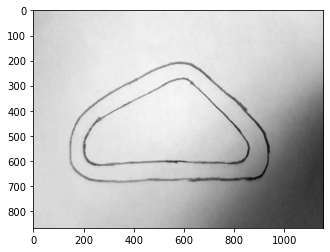

In [6]:
path_to_image = "/mnt/c/Users/papal/Documents/fasttube/2022/experiments/drawing-to-track/images/image4.jpg"
# path_to_image = "images/image5.jpg"


image_gray = io.imread(path_to_image, as_gray=True)

image_resolution = np.prod(image_gray.shape[:2])
target_resolution = 1000 * 1000

# rescale to desired resolution
rescale_ratio = round(target_resolution / image_resolution, 3)
print(f'Rescaling image by factor {rescale_ratio}')
# we square root because scale refers to each dimension separately
image_resized = rescale(image_gray, rescale_ratio**0.5)
# boost contrast
image_boost_contrast = image_resized.copy() if 1 else rescale_intensity(image_resized)
plt.imshow(image_boost_contrast, cmap="gray")

# Extract track edges

There are two methods to extract the track edges. If your input is already a binarized image of track edges then you should use the threshold method. If your input is an image of a "handwritten" track or your input has the track "filled in" (the track is coloured in), then you should use the canny method.

## Canny
- We use canny edge detection to extract the track edges.
- The canny_sigma variable defines the sensitivity of the algorithm.
- Adjust it up until the edges of the track are clearly visible and connected, and other edges are mostly not present.
- If your input is a filled in track then the gaussian blur is not relevant (you can set it to zero).
- If your input are the track edges then the canny output needs to be blurred. This is because canny will produce a double edge for the track edges (the rise and fall of the edge). By blurring the image a little bit we can combine the double edges into a single one.
- The thickness of the edge will be addressed in the next step. In order to address the new thicker edges, we apply an algorithm to make the edges thinner. You don't have to worry in case your input does not need blurring, the algorithm will keep thin edges in place. 

## Simpler alternative

If you already have a binarized image (because you used a digitizer instead of drawing on a physical paper), then you probably want to use a simple threshold value. Adjust the threshold variable so that the track edges are visible.

0.6547339019539653 0.15887487259750388


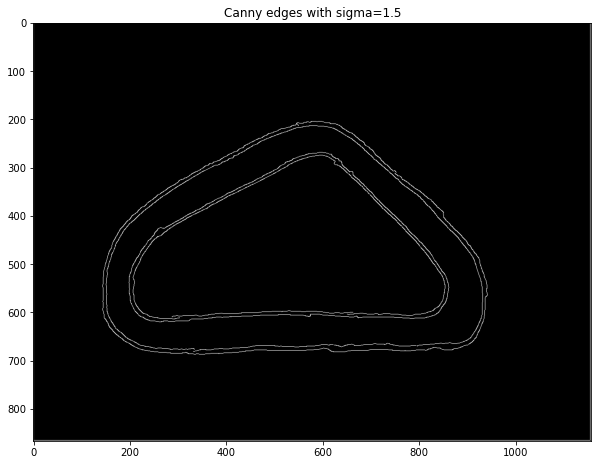

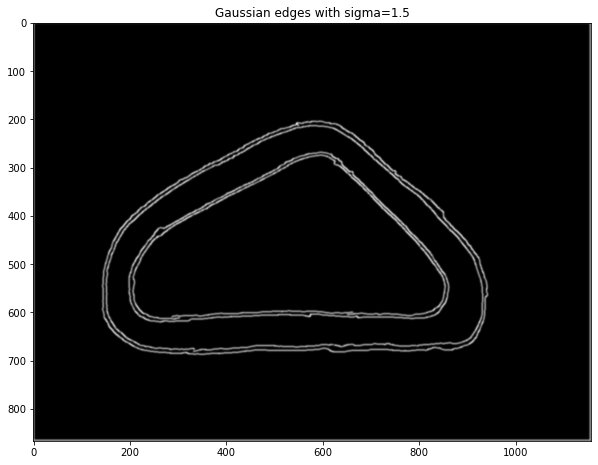

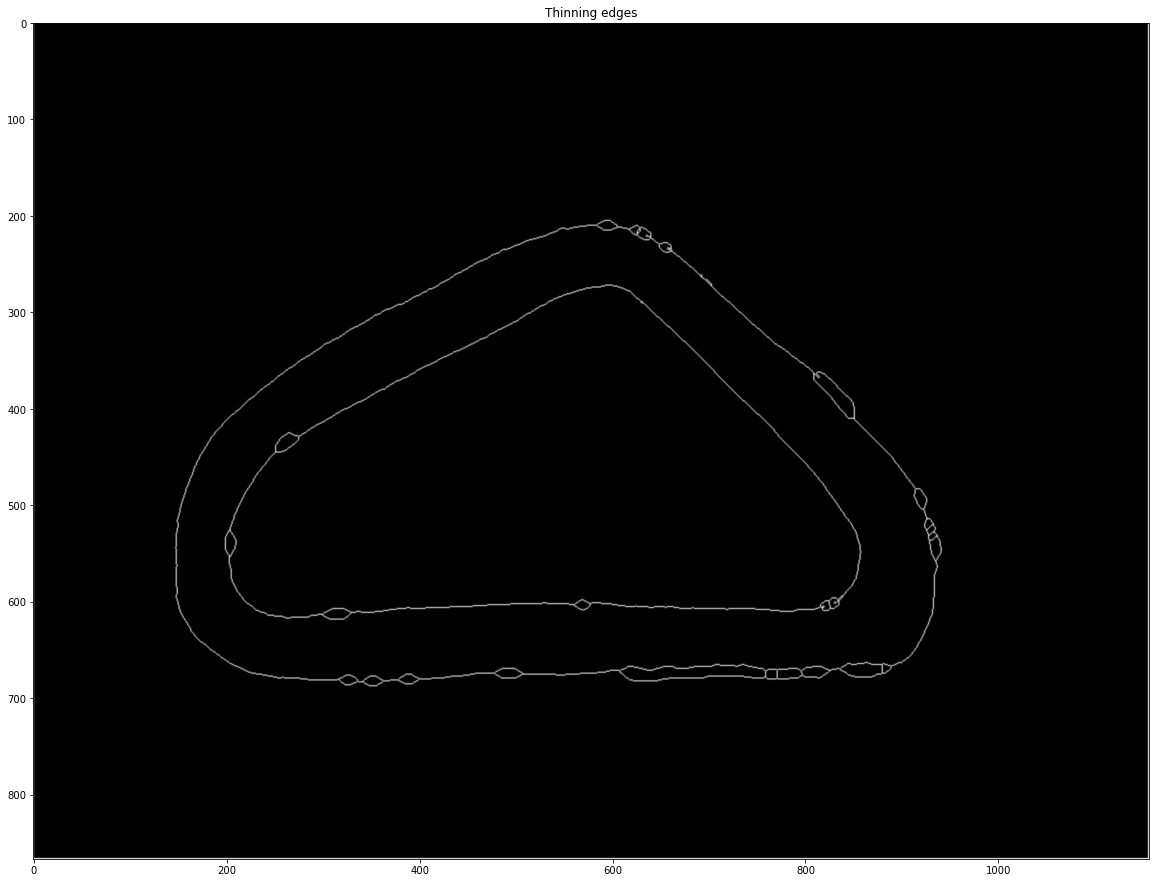

In [9]:
method_canny = 1


if method_canny:
    do_thinning = True
    canny_sigma = 1.5
    gaussian_sigma = 1.5
    print(image_boost_contrast.max(), image_boost_contrast.min())
    canny_edges = canny(image_boost_contrast, sigma=canny_sigma)
    plt.figure(figsize=(10,10))
    plt.imshow(canny_edges, cmap="gray")
    plt.title(f"Canny edges with sigma={canny_sigma}")
    plt.show()
    gaussian_edges = gaussian(canny_edges, gaussian_sigma)
    plt.figure(figsize=(10,10))
    plt.imshow(gaussian_edges, cmap="gray")
    plt.title(f"Gaussian edges with sigma={gaussian_sigma}")
    plt.show()

    if do_thinning:
        edges = thinning.guo_hall_thinning((gaussian_edges * 255).astype(np.uint8)) > 0
    else:
        edges = gaussian_edges
    


else:
    threshold = 0.5

    edges_raw = (image_boost_contrast < threshold).astype(float)
    edges = thinning.guo_hall_thinning((edges_raw * 255).astype(np.uint8)) > 0
    

plt.figure(figsize=(20,20))
plt.title(f"Thinning edges")
plt.imshow(edges, cmap="gray", interpolation="bicubic")


# Split inside and outside track edges

- We want to split the inside and outside track edges.
- For this we will create a graph of pixels that are connected to each other.
- Only pixels that are "on" after edge extraction are considered.
- The pixels are randomized to remove the effect of the order of the pixels.
- Pixels are connected to each other if they are close enough.
- The maximum distance between two pixels is defined by the **max_distance** variable.
- 'cityblock'/'manhattan' distance is used.
- After the graph has been constructed, the connected components are found.
- Only the two largest components are kept. All other components are discarded.
- The two largest components should contain a similar number of datapoints and any other components should contain a very small number of points. If that is not the case adjust the max_distance variable.
- If too many components with a small number of elements are present then the distance is too low. If only one large components is created then the distance is too high.


In [122]:
maximum_distance = 4

ratio_keep = 1

# create distance matrix
points = np.argwhere(edges)

points_keep = (points[:,0] > 1) * (points[:,0] < edges.shape[0] - 1) * (points[:,1] > 1) * (points[:,1] < edges.shape[1] - 1)

points = points[points_keep]



points_idxs = np.linspace(0, len(points)-1, int(len(points) * ratio_keep), dtype=int)
print(len(points))
points = points[points_idxs]
print(len(points))

distances = pairwise_distances(points, points)
print(distances.shape)
# create graph
print('calulating connections')
connections = np.logical_and(distances > 0, distances <= maximum_distance)
print(connections.shape)

# find connected components
number_of_components, labels = connected_components(connections)
print(labels.shape)
print(number_of_components)
# only keep two largest components
unique_labels, counts = np.unique(labels, return_counts=True)
print(counts)
unique_labels_sorted_by_count = unique_labels[np.argsort(counts)]
two_largest_components = unique_labels_sorted_by_count[-2:]
lines_points = [points[label == labels] for label in two_largest_components]

9885
9885
(9885, 9885)
calulating connections
(9885, 9885)
(9885,)
2
[4986 4899]


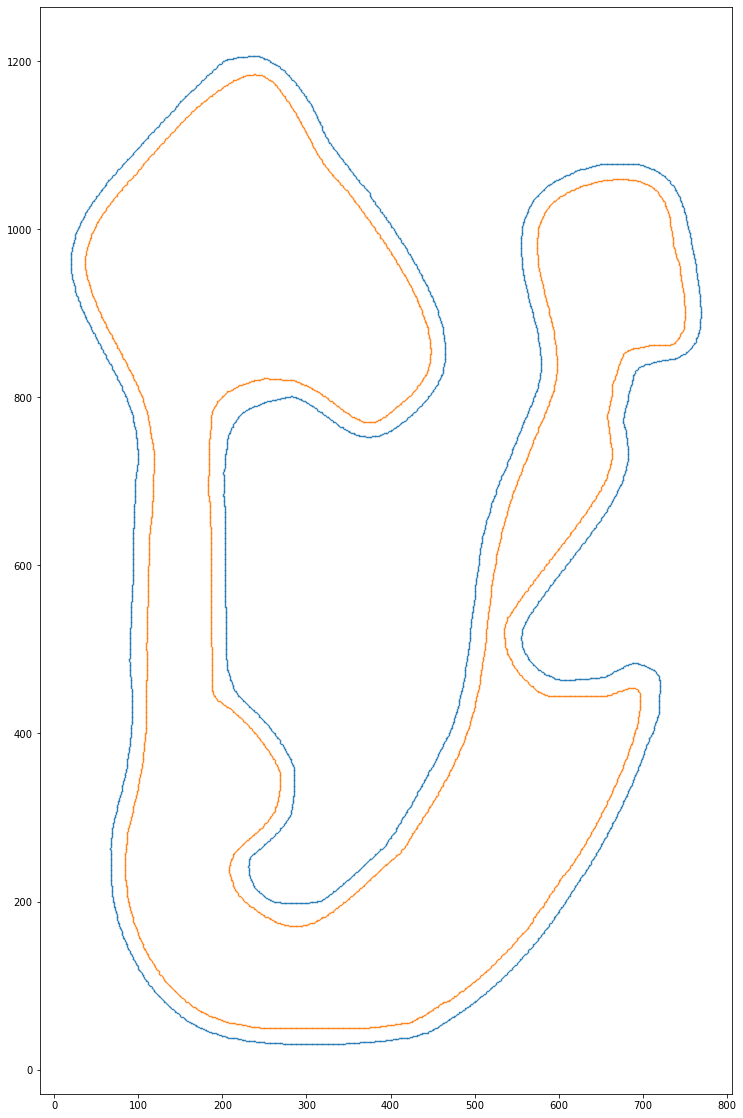

In [123]:
plt.figure(figsize=(20,20))
for l in unique_labels:
    plt.plot(*points[labels==l].T, '.', markersize=1)
plt.gca().set_aspect("equal", adjustable="box")

# Get order from track edges

The edges that we have now are simple 2d point clouds. We need to extract direction from them. Ideally the algorithms described in [this paper](https://www.rechenraum.com/de/assets/publications/simon_floery_da.pdf) should be used. However, I have not attempted this. Initially alphashapes were used but they are limited in the shapes that the can model, before they fall back to multiple polygons.

The algorithm that we use starts from the first node of the graph that was created before and visits the next node that keeps to the direction of the current node. This is done until the initial node is reached again. This is not a very stable algorithm. However it works better than the alphashape method. If the algorithm does not work then try to change the number of points that are bering extracted in the step above. This usually helps.

In [124]:

def walk_through_track(connections: np.ndarray, positions: np.ndarray, start_index: int) -> Iterable[int]:
    current_index = start_index
    
    yield current_index
    neighbor = np.where(connections[current_index])[0][0]
    yield neighbor

    seen = {current_index, neighbor}


    min_steps = 50
    for i in count():
        neighbors = np.where(connections[neighbor])[0]
        next_indices = list(set(neighbors) - seen)

        if len(next_indices) == 0:
            print('stop')
            break
        

        v1 = positions[current_index] - positions[neighbor]
        v2 = positions[neighbor] - positions[next_indices]

        
        d = np.dot(v2, v1)
        
        next_index_index = np.argmax(d)
        next_index = next_indices[next_index_index]


        if i > min_steps:
            dist = np.linalg.norm(positions[start_index] - positions[next_index])
            
            if dist < 20:
                do_print = True
                break

        yield next_index
        seen.add(next_index)
        current_index = neighbor
        neighbor = next_index

(1582, 2)
(1623, 2)


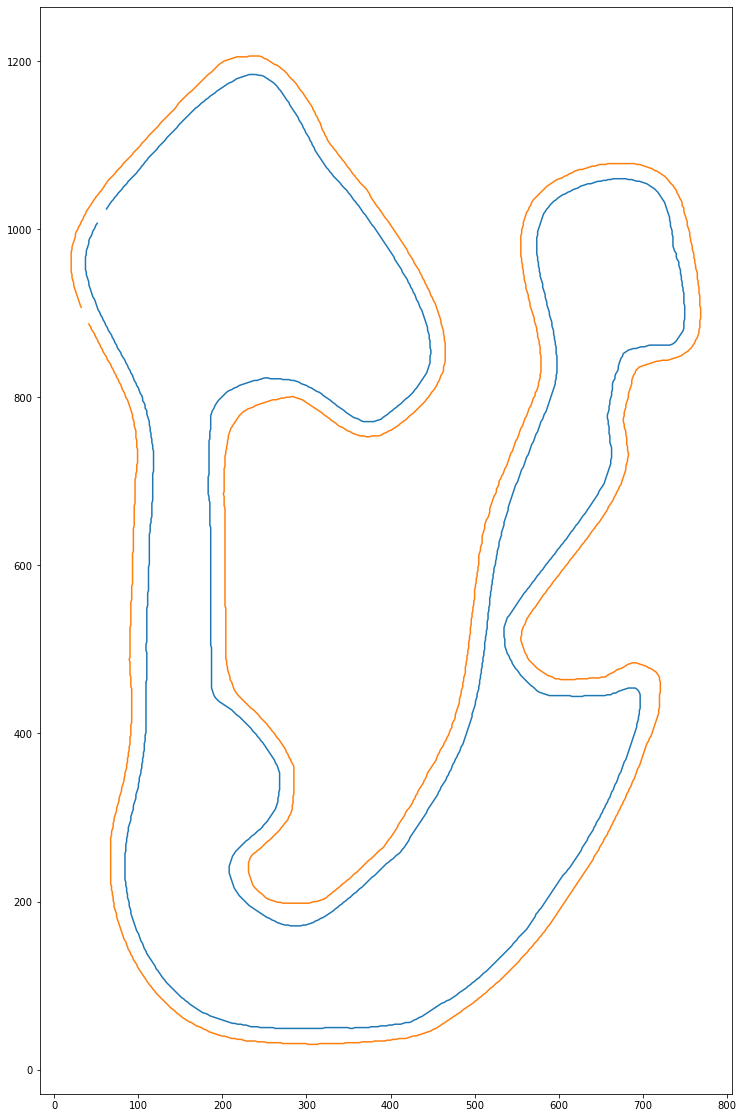

In [125]:


plt.figure(figsize=(20,20))
points_sorted = []


for component_id in two_largest_components:
    start_index_for_component = np.where(labels == component_id)[0][100]
    
    idxs = list(walk_through_track(connections, points, start_index=start_index_for_component))
        
    points_walk = points[idxs]

    print(points_walk.shape)


    points_sorted.append(points_walk)

    
    plt.plot(*points_walk.T, '-')
    plt.gca().set_aspect("equal", adjustable="box")

    do_half = True


# Fix points orientation and normalize scale

- The orientation of the track has changed (because we have moved from pixel-space to world-space).
- Pixel-space has its origin on the top left corner.
- World-space has its origin on the bottom left corner.
- In the next cell we fix the orientation of the track.
- We also normalize the scale of the track. The points are now in a [0,1] range.

1582
1623


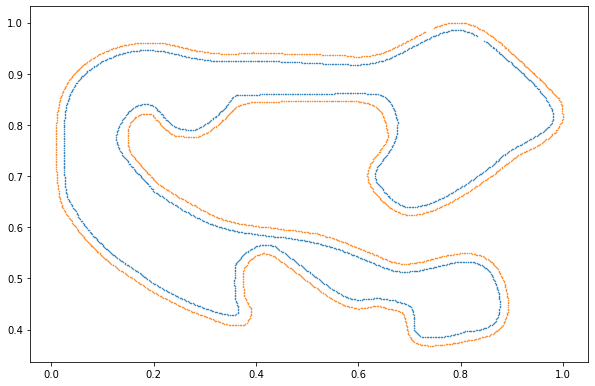

In [126]:
all_points = np.concatenate(points_sorted)

# peak to peak (max - min)
ptp = np.ptp(all_points)
min_value = np.min(all_points)
# min-max scaling
lines_points_scaled = [(points - min_value) / ptp for points in points_sorted]

# orientation fix
lines_points_fix_orientation = [
    ((rotate_image(points, 180) * [1, -1]) + [0, 1]) for points in lines_points_scaled
]

plt.figure(figsize=(10,10))
for p in lines_points_fix_orientation:
    plt.plot(*p.T, '.', markersize=1)

    print(len(p))
    
plt.gca().set_aspect("equal", adjustable="box")


# Fitting a spline to the track edge

- Each track edge is represented by a list of points.
- We want to fit a spline to the track edge.
- The spline is a piecewise cubic parametric polynomial.
- We use the wrapper in `chabo_common` to fit the spline.
- The spline fits the track edge "thrice", then the middle fit is selected.
- This ensures that the spline is smooth at the start/finish area.

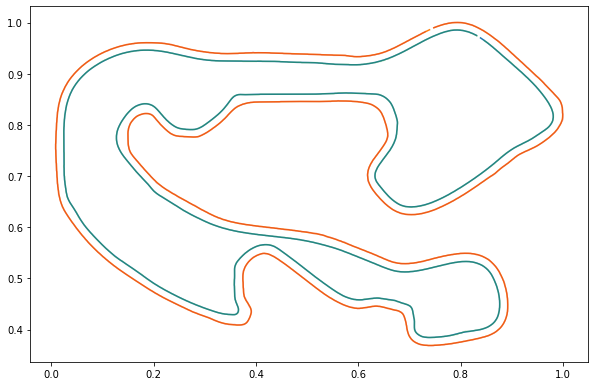

In [127]:
fitter_factory = SplineFitterFactory(smoothing=0.0001, predict_every=0.001, max_deg=5)

splined_traces = []

plt.figure(figsize=(10, 8))
for p in lines_points_fix_orientation:
    # stack edge points thrice
    alpha_points_tiled = np.tile(p[:-1], (3, 1))

    # create spline and evaluate it
    spline_points = fitter_factory.fit(alpha_points_tiled[::3]).predict(der=0)
    l = len(spline_points)
    # get middle third of evaluated spline
    spline_points = spline_points[l // 3 : 2 * l // 3]

    splined_traces.append(spline_points)
    plt.plot(*spline_points[:].T, "-")


for p in lines_points_fix_orientation:
    plt.plot(*p.T, '-', markersize=1, alpha=0.4)


plt.gca().set_aspect("equal", adjustable="box")


# Scale to real world units

- The minimum track width is 3 meters.
- We calculate the distance between all points from one edge to the other.
- We pick the smallest distance.
- This value is used as an anchor point for the scaling.
- The scale is calculated as the minimum track width divided by the smallest distance.


1300 3174


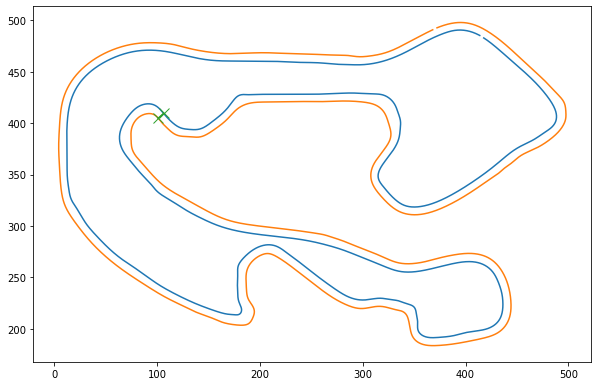

In [128]:
minimum_track_width = 7

# calculate minimum distance between track edges
distances = pairwise_distances(splined_traces[0], splined_traces[1])

min_distance = distances.min()
index_min_distance_left, index_min_distance_right = np.argwhere(distances == min_distance)[0]


# calculate scale factor
scale = minimum_track_width / min_distance

# scale points of track edges
spline_points_scaled = [scale * points for points in splined_traces]

plt.figure(figsize=(10, 8))

for p in spline_points_scaled:
    plt.plot(*p[:].T)
print(index_min_distance_left, index_min_distance_right)
left_min_point = spline_points_scaled[0][index_min_distance_left]
right_min_point = spline_points_scaled[1][index_min_distance_right]
plt.plot([left_min_point[0], right_min_point[0]], [left_min_point[1], right_min_point[1]], 'x-', markersize=10)

plt.gca().set_aspect("equal", adjustable="box")


# Algorithm to place cones on track edges

- Algorithm taken from track_designer

In [129]:
def place_cones(
    trace: np.ndarray, seed: int, mean: float, variance: float
) -> np.ndarray:

    rng = np.random.default_rng(seed)

    idxs_to_keep = [0]
    next_distance = rng.normal(mean, variance)
    next_idx = idxs_to_keep[0]
    while next_idx < len(trace):
        
        trace_from_last_in = trace[next_idx:]
        cum_dist = np.cumsum(trace_distance_to_next(trace_from_last_in))

        offset_next_idx = np.argmax(cum_dist > next_distance)

        if offset_next_idx == 0:
            break

        next_idx = offset_next_idx + next_idx
        idxs_to_keep.append(next_idx)
        next_distance = rng.normal(mean, variance)

    randomly_placed_cones = trace[idxs_to_keep]

    first_cone, last_cone = randomly_placed_cones[0], randomly_placed_cones[-1]
    first_cone_distance = np.linalg.norm(first_cone - last_cone)
    if first_cone_distance > 2 * mean:
        new_last_cone = (first_cone + last_cone) / 2

        randomly_placed_cones = np.row_stack([randomly_placed_cones, new_last_cone])

    return randomly_placed_cones

# Cone placement on track edges

- A start position and angle is needed.
- The start position is a point between the track edges. It defines the position of the start/finish line.
- The start angle defines the direction of the track
- The distance between cones is defines by a gaussian distribution.
- mean and variance are the parameters of this gaussian distribution.


0.0
120
405


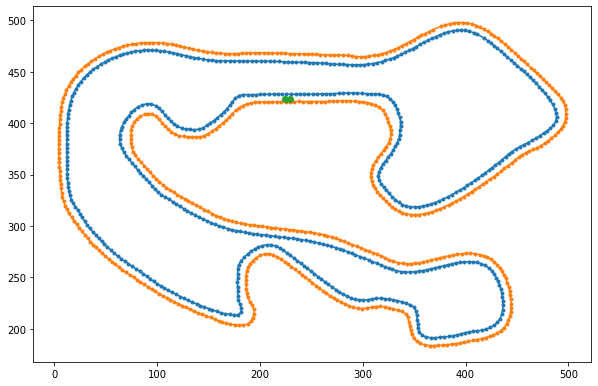

In [130]:
start_position = np.array([0.45, 0.85]) * scale
start_angle = np.deg2rad(0)

mean = 4.5
variance = 0.2
print(start_angle)
start_direction = unit_2d_vector_from_angle(start_angle)

cone_traces = []

plt.figure(figsize=(10, 8))

for trace in spline_points_scaled[:]:
    # put cones on trace
    cone_trace = place_cones(trace, seed=2, mean=mean, variance=variance)
    # find the cone closest to the start position
    # this is the first cone of the edge
    start_cone_index = np.argmin(np.linalg.norm(cone_trace - start_position, axis=1))

    print(start_cone_index)

    # find the next cone (according to the track direction)
    # for the cone immediately before and after the start cone
    for next_cone_index in (start_cone_index - 1, start_cone_index + 1):
        # get the vector that points from the start cone to the next cone
        vec = normalize(cone_trace[next_cone_index] - cone_trace[start_cone_index])
        # get the dot product to the start direction
        # if the value is positive, then the cone is in the same direction as the start cone
        sign = np.dot(start_direction, vec)
        if sign > 0:
            break

    # roll the cone trace so that the start cone is the first element
    # if needed invert the order of the cones (if the second cone according to the start
    # direction is behind the first)
    sign = np.sign(next_cone_index - start_cone_index)
    cone_trace = np.roll(cone_trace, -start_cone_index, axis=0)
    if sign < 1:
        cone_trace = np.roll(cone_trace[::-1], 1, axis=0)

    cone_traces.append(cone_trace)

    plt.plot(*cone_trace[:].T, ".-")

start = np.row_stack([start_position, start_position + start_direction * 5])
plt.plot(*start.T, "o-")
plt.gca().set_aspect("equal", adjustable="box")


# Determine cone color (blue, yellow)

- The color of the cones is determined by the track direction.
- Cones on the left side of the track are blue.
- Cones on the right side of the track are yellow.
- The "side-ness" (if an edge represents the left or right side of the track) of each edge is determined by the start angle
- The track is translated and rotated to the start position and start angle.
- At the point the the start position is on [0,0] and the start angle is 0
- This means that the y component of the first cone of the left edge is positive.
- Consequently, the first cone of the right edge is negative.
- This way we determine the color of the cones for each edge.

first is left


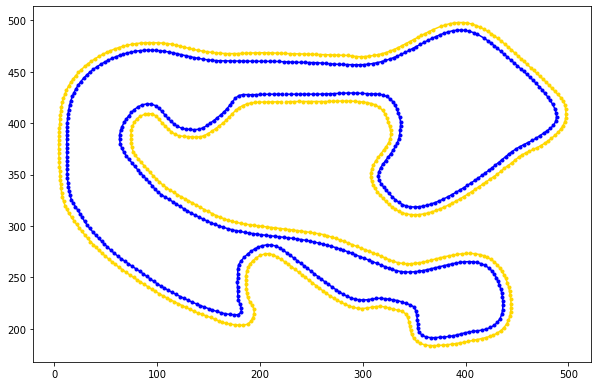

In [131]:
cone_traces_normalized = []

middle = (cone_traces[0][0] + cone_traces[1][0]) / 2

for cone_trace in cone_traces:
    # normalize cone trace
    cone_trace = cone_trace - middle
    cone_trace = rotate_points(cone_trace[:1], -start_angle)
    cone_traces_normalized.append(cone_trace)

if cone_traces_normalized[0][0, 1] > 0:
    print("first is left")
    left, right = cone_traces
else:
    print("first is right")
    right, left = cone_traces


plt.figure(figsize=(10, 10))
plt.plot(*left.T, ".-", color="blue")
plt.plot(*right.T, ".-", color="gold")

plt.gca().set_aspect("equal", adjustable="box")


# Export

- We are done with the processing
- We need to pick a world an a layout name.
- `LA2` is recommended for world name.
- The layout name can be picked by the user.

In [132]:
layout_name = "my_track_ext2"

world_name = "LA2"

empty = np.zeros((0, 2))

all_cones_mean = np.row_stack([left, right]).mean(axis=0)
left = left - all_cones_mean
right = right - all_cones_mean


left_cones = left[1:]
right_cones = right[1:]
orange_big = np.row_stack([left[:1], right[:1]])

traces = [empty, right_cones, left_cones, empty, orange_big]

write_traces_as_lyt(world_name, layout_name, traces)

4.124386376837123
/mnt/c/LFS/data/layout/LA2_my_track_ext2.lyt
